# Example 8: Improving moment estimation

This example will show how to improve the estimation of both low and higher order moments using denoising and sparsification techniques.

In [1]:
using PortfolioOptimisers, PrettyTables
# Format for pretty tables.
tsfmt = (v, i, j) -> begin
    if j == 1
        return Date(v)
    else
        return v
    end
end;
resfmt = (v, i, j) -> begin
    if j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    end
end;
mipresfmt = (v, i, j) -> begin
    if j ∈ (1, 2, 3)
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    end
end;
mmtfmt = (v, i, j) -> begin
    if i == j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    end
end;
hmmtfmt = (v, i, j) -> begin
    if i == j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100*1e4, digits=2))e-4 %" : v
    end
end;

## 1. ReturnsResult data

We will use the same data as the previous example. But we will also load factor data.

In [2]:
using CSV, TimeSeries, DataFrames

X = TimeArray(CSV.File(joinpath(@__DIR__, "SP500.csv.gz")); timestamp = :Date)[(end - 252):end]
pretty_table(X[(end - 5):end]; formatters = [tsfmt])

F = TimeArray(CSV.File(joinpath(@__DIR__, "Factors.csv.gz")); timestamp = :Date)[(end - 252):end]
pretty_table(F[(end - 5):end]; formatters = [tsfmt])

# Compute the returns
rd = prices_to_returns(X, F)

┌────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬──────
│  timestamp │    AAPL │     AMD │     BAC │     BBY │     CVX │      GE │     ⋯
│       Date │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Flo ⋯
├────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────
│ 2022-12-20 │ 131.916 │   65.05 │  31.729 │  77.371 │ 169.497 │  62.604 │ 310 ⋯
│ 2022-12-21 │ 135.057 │   67.68 │  32.212 │  78.729 │  171.49 │   64.67 │ 314 ⋯
│ 2022-12-22 │ 131.846 │   63.86 │  31.927 │  78.563 │ 168.918 │  63.727 │ 311 ⋯
│ 2022-12-23 │ 131.477 │   64.52 │  32.005 │  79.432 │  174.14 │  63.742 │ 314 ⋯
│ 2022-12-27 │ 129.652 │   63.27 │  32.065 │   79.93 │ 176.329 │  64.561 │ 314 ⋯
│ 2022-12-28 │ 125.674 │   62.57 │  32.301 │  78.279 │ 173.728 │  63.883 │  31 ⋯
└────────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴──────
                                                              14 columns omitted
┌────────────┬─────────┬────

ReturnsResult
    nx ┼ 20-element Vector{String}
     X ┼ 252×20 Matrix{Float64}
    nf ┼ Vector{String}: ["MTUM", "QUAL", "SIZE", "USMV", "VLUE"]
     F ┼ 252×5 Matrix{Float64}
    ts ┼ 252-element Vector{Date}
    iv ┼ nothing
  ivpa ┴ nothing


## 2. Prior statistics

Here we will only use empirical priors but with denoising and sparsification techniques applied.

For denoising we will use `Denoise`, and all its associated algorithms `ShrunkDenoise`, `FixedDenoise`, and `SpectralDenoise`, though the last one may not always produce a matrix with a lower condition number.

For sparsification we will use the relationship structure to sparsify the inverse of the matrix using `LoGo` with two different distance matrix similarity measures, `MaximumDistanceSimilarity` and `ExponentialSimilarity`.

We will also improve the estimation of the mean return by using a shrunk expected returns estimator `ShrunkExpectedReturns` using `BayesStein` and `BodnarOkhrinParolya` algorithms with all three available expected returns shrinkage targets `GrandMean`, `VolatilityWeighted`, and `MeanSquaredError`.

In [3]:
pes = [EmpiricalPrior(;),#
       EmpiricalPrior(;
                      me = ShrunkExpectedReturns(;
                                                 alg = BayesStein(;
                                                                  tgt = VolatilityWeighted())),#
                      ce = PortfolioOptimisersCovariance(;
                                                         mp = DenoiseDetoneAlgMatrixProcessing(;
                                                                                               dn = Denoise(;
                                                                                                            alg = FixedDenoise())))),#
       EmpiricalPrior(;
                      me = ShrunkExpectedReturns(;
                                                 alg = BayesStein(;
                                                                  tgt = MeanSquaredError())),#
                      ce = PortfolioOptimisersCovariance(;
                                                         mp = DenoiseDetoneAlgMatrixProcessing(;
                                                                                               alg = LoGo()))),
       HighOrderPriorEstimator(;
                               pe = EmpiricalPrior(;
                                                   ce = PortfolioOptimisersCovariance(;
                                                                                      mp = DenoiseDetoneAlgMatrixProcessing(;
                                                                                                                            dn = Denoise(;
                                                                                                                                         alg = ShrunkDenoise(;
                                                                                                                                                             alpha = 0.5)))),
                                                   me = ShrunkExpectedReturns(;
                                                                              alg = BodnarOkhrinParolya()))),
       HighOrderPriorEstimator(;
                               pe = EmpiricalPrior(;
                                                   me = ShrunkExpectedReturns(;
                                                                              alg = BodnarOkhrinParolya(;
                                                                                                        tgt = VolatilityWeighted())),
                                                   ce = PortfolioOptimisersCovariance(;
                                                                                      mp = DenoiseDetoneAlgMatrixProcessing(;
                                                                                                                            alg = LoGo(),
                                                                                                                            dn = Denoise(;
                                                                                                                                         alg = FixedDenoise())))),
                               ske = Coskewness(;
                                                mp = DenoiseDetoneAlgMatrixProcessing(;
                                                                                      dn = Denoise(;
                                                                                                   alg = FixedDenoise()))),
                               kte = Cokurtosis(;
                                                mp = DenoiseDetoneAlgMatrixProcessing(;
                                                                                      dn = Denoise(;
                                                                                                   alg = FixedDenoise())))),
       HighOrderPriorEstimator(;
                               pe = EmpiricalPrior(;
                                                   me = ShrunkExpectedReturns(;
                                                                              alg = BodnarOkhrinParolya(;
                                                                                                        tgt = MeanSquaredError())),
                                                   ce = PortfolioOptimisersCovariance(;
                                                                                      mp = DenoiseDetoneAlgMatrixProcessing(;
                                                                                                                            alg = LoGo(;
                                                                                                                                       sim = ExponentialSimilarity())))),
                               ske = Coskewness(;
                                                mp = DenoiseDetoneAlgMatrixProcessing(;
                                                                                      dn = Denoise(),
                                                                                      alg = LoGo())),
                               kte = Cokurtosis(;
                                                mp = DenoiseDetoneAlgMatrixProcessing(;
                                                                                      dn = Denoise(),
                                                                                      alg = LoGo())))]

6-element Vector{AbstractPriorEstimator}:
 EmpiricalPrior
       ce ┼ PortfolioOptimisersCovariance
          │   ce ┼ Covariance
          │      │    me ┼ SimpleExpectedReturns
          │      │       │   w ┴ nothing
          │      │    ce ┼ GeneralCovariance
          │      │       │   ce ┼ SimpleCovariance: SimpleCovariance(true)
          │      │       │    w ┴ nothing
          │      │   alg ┴ Full()
          │   mp ┼ DenoiseDetoneAlgMatrixProcessing
          │      │     pdm ┼ Posdef
          │      │         │      alg ┼ UnionAll: NearestCorrelationMatrix.Newton
          │      │         │   kwargs ┴ @NamedTuple{}: NamedTuple()
          │      │      dn ┼ nothing
          │      │      dt ┼ nothing
          │      │     alg ┼ nothing
          │      │   order ┴ DenoiseDetoneAlg()
       me ┼ SimpleExpectedReturns
          │   w ┴ nothing
  horizon ┴ nothing

 EmpiricalPrior
       ce ┼ PortfolioOptimisersCovariance
          │   ce ┼ Covariance
          │      │

Now let's compute the prior statistics for each estimator.

In [4]:
prs = prior.(pes, rd)

6-element Vector{AbstractPriorResult}:
 LowOrderPrior
        X ┼ 252×20 Matrix{Float64}
       mu ┼ 20-element Vector{Float64}
    sigma ┼ 20×20 Matrix{Float64}
     chol ┼ nothing
        w ┼ nothing
      ens ┼ nothing
      kld ┼ nothing
       ow ┼ nothing
       rr ┼ nothing
     f_mu ┼ nothing
  f_sigma ┼ nothing
      f_w ┴ nothing

 LowOrderPrior
        X ┼ 252×20 Matrix{Float64}
       mu ┼ 20-element Vector{Float64}
    sigma ┼ 20×20 Matrix{Float64}
     chol ┼ nothing
        w ┼ nothing
      ens ┼ nothing
      kld ┼ nothing
       ow ┼ nothing
       rr ┼ nothing
     f_mu ┼ nothing
  f_sigma ┼ nothing
      f_w ┴ nothing

 LowOrderPrior
        X ┼ 252×20 Matrix{Float64}
       mu ┼ 20-element Vector{Float64}
    sigma ┼ 20×20 Matrix{Float64}
     chol ┼ nothing
        w ┼ nothing
      ens ┼ nothing
      kld ┼ nothing
       ow ┼ nothing
       rr ┼ nothing
     f_mu ┼ nothing
  f_sigma ┼ nothing
      f_w ┴ nothing

 HighOrderPrior
    pr ┼ LowOrderPrior
       │  

### 2.1 Expected returns

First let's view the expected returns.

In [5]:
pretty_table(DataFrame("Assets" => rd.nx, "Vanilla" => prs[1].mu, "BS(VW)" => prs[2].mu,
                       "BS(MSE)" => prs[3].mu, "BOP(GM)" => prs[4].mu,
                       "BOP(VW)" => prs[5].mu, "BOP(MSE)" => prs[6].mu);
             formatters = [mmtfmt], title = "Expected returns")

                              Expected returns
┌────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ Assets │  Vanilla │   BS(VW) │  BS(MSE) │  BOP(GM) │  BOP(VW) │ BOP(MSE) │
│ String │  Float64 │  Float64 │  Float64 │  Float64 │  Float64 │  Float64 │
├────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│   AAPL │ -0.113 % │  0.009 % │ -0.045 % │  0.064 % │  0.082 % │  0.063 % │
│    AMD │ -0.281 % │ -0.056 % │ -0.116 % │  0.158 % │  0.176 % │  0.157 % │
│    BAC │ -0.093 % │  0.016 % │ -0.037 % │  0.053 % │  0.071 % │  0.052 % │
│    BBY │ -0.028 % │  0.042 % │  -0.01 % │  0.016 % │  0.034 % │  0.016 % │
│    CVX │  0.195 % │  0.128 % │  0.084 % │ -0.108 % │  -0.09 % │ -0.109 % │
│     GE │ -0.034 % │  0.039 % │ -0.012 % │   0.02 % │  0.038 % │  0.019 % │
│     HD │ -0.071 % │  0.025 % │ -0.028 % │   0.04 % │  0.058 % │   0.04 % │
│    JNJ │  0.031 % │  0.064 % │  0.015 % │ -0.017 % │  0.001 % │ -0.017 % │
│    JPM │ -0.042 % │  0.036 

### 2.2 Covariance matrices

We can now see how the different denoising and sparsification techniques improve the covariance matrix's condition number.

In [6]:
using LinearAlgebra

pretty_table(DataFrame([rd.nx prs[1].sigma], ["Assets"; rd.nx]); formatters = [mmtfmt],
             title = "Covariance: Vanilla",
             source_notes = "Condition number Vanilla: $(round(cond(prs[1].sigma); digits = 3))")
pretty_table(DataFrame([rd.nx prs[2].sigma], ["Assets"; rd.nx]); formatters = [mmtfmt],
             title = "Covariance: Fixed denoise",
             source_notes = "Condition number fixed denoise: $(round(cond(prs[2].sigma); digits = 3))")
pretty_table(DataFrame([rd.nx prs[3].sigma], ["Assets"; rd.nx]); formatters = [mmtfmt],
             title = "Covariance: LoGo(MaxDist)",
             source_notes = "Condition number LoGo(MaxDist): $(round(cond(prs[3].sigma); digits = 3))")
pretty_table(DataFrame([rd.nx prs[4].sigma], ["Assets"; rd.nx]); formatters = [mmtfmt],
             title = "Covariance: Shrunk denoise (0.5)",
             source_notes = "Condition number Shrunk denoise (0.5): $(round(cond(prs[4].sigma); digits = 3))")
pretty_table(DataFrame([rd.nx prs[5].sigma], ["Assets"; rd.nx]); formatters = [mmtfmt],
             title = "Covariance: FixedDenoise + LoGo(MaxDist)",
             source_notes = "Condition number FixedDenoise + LoGo(MaxDist): $(round(cond(prs[5].sigma); digits = 3))")
pretty_table(DataFrame([rd.nx prs[6].sigma], ["Assets"; rd.nx]); formatters = [mmtfmt],
             title = "Covariance: LoGo(ExpDist)",
             source_notes = "Condition number LoGo(ExpDist): $(round(cond(prs[6].sigma); digits = 3))")

                              Covariance: Vanilla
┌────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬──────────
│ Assets │    AAPL │     AMD │     BAC │     BBY │     CVX │      GE │      HD ⋯
│    Any │     Any │     Any │     Any │     Any │     Any │     Any │     Any ⋯
├────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────
│   AAPL │  0.05 % │ 0.063 % │ 0.026 % │ 0.034 % │ 0.014 % │ 0.027 % │ 0.026 % ⋯
│    AMD │ 0.063 % │ 0.147 % │ 0.044 % │ 0.057 % │ 0.025 % │ 0.049 % │ 0.039 % ⋯
│    BAC │ 0.026 % │ 0.044 % │ 0.042 % │ 0.026 % │ 0.015 % │ 0.028 % │ 0.017 % ⋯
│    BBY │ 0.034 % │ 0.057 % │ 0.026 % │ 0.081 % │ 0.013 % │ 0.027 % │ 0.037 % ⋯
│    CVX │ 0.014 % │ 0.025 % │ 0.015 % │ 0.013 % │ 0.043 % │ 0.017 % │ 0.007 % ⋯
│     GE │ 0.027 % │ 0.049 % │ 0.028 % │ 0.027 % │ 0.017 % │ 0.048 % │ 0.017 % ⋯
│     HD │ 0.026 % │ 0.039 % │ 0.017 % │ 0.037 % │ 0.007 % │ 0.017 % │ 0.039 % ⋯
│    JNJ │ 0.009 % │ 0.008 % │ 0.007 % │ 0.009 % │ 0.003 % 

### 2.3 Higher order moments

Now let's view how the higher order moments benefit from denoising. The coskewness matrix is not affected because it's not square, but the matrix of negative spectral slices is.

In [7]:
nx2 = collect(Iterators.flatten([(nx * "_") .* rd.nx for nx in rd.nx]))

pretty_table(DataFrame([rd.nx prs[4].V], ["Assets"; rd.nx]); formatters = [hmmtfmt],
             title = "Coskewness Negative Spectral Slices: Vanilla",
             source_notes = "Condition number Vanilla: $(round(cond(prs[4].V); digits = 3))")
pretty_table(DataFrame([rd.nx prs[5].V], ["Assets"; rd.nx]); formatters = [hmmtfmt],
             title = "Coskewness Negative Spectral Slices: FixedDenoise",
             source_notes = "Condition number FixedDenoise: $(round(cond(prs[5].V); digits = 3))")
pretty_table(DataFrame([rd.nx prs[6].V], ["Assets"; rd.nx]); formatters = [hmmtfmt],
             title = "Coskewness Negative Spectral Slices: LoGo(MaxDist)",
             source_notes = "Condition number LoGo(MaxDist): $(round(cond(prs[6].V); digits = 3))")

                  Coskewness Negative Spectral Slices: Vanilla
┌────────┬────────────┬────────────┬────────────┬────────────┬────────────┬─────
│ Assets │       AAPL │        AMD │        BAC │        BBY │        CVX │    ⋯
│    Any │        Any │        Any │        Any │        Any │        Any │    ⋯
├────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────
│   AAPL │ 10.95e-4 % │  8.74e-4 % │  0.42e-4 % │ 11.72e-4 % │  6.82e-4 % │  8 ⋯
│    AMD │  8.74e-4 % │ 39.47e-4 % │  3.05e-4 % │ 10.18e-4 % │ 16.53e-4 % │ 23 ⋯
│    BAC │  0.42e-4 % │  3.05e-4 % │  4.83e-4 % │  3.92e-4 % │ -0.99e-4 % │  0 ⋯
│    BBY │ 11.72e-4 % │ 10.18e-4 % │  3.92e-4 % │ 44.51e-4 % │  3.51e-4 % │  6 ⋯
│    CVX │  6.82e-4 % │ 16.53e-4 % │ -0.99e-4 % │  3.51e-4 % │ 31.05e-4 % │ 14 ⋯
│     GE │  8.11e-4 % │ 23.22e-4 % │  0.02e-4 % │  6.39e-4 % │ 14.81e-4 % │ 37 ⋯
│     HD │  8.11e-4 % │   1.1e-4 % │  2.36e-4 % │ 21.55e-4 % │ -1.51e-4 % │  1 ⋯
│    JNJ │  2.67e-4 % │  0.82e-4 % │ -0.36e-4 

And finally the cokurtosis.

In [8]:
pretty_table(DataFrame([nx2 prs[4].kt], ["Assets^2"; nx2]); formatters = [hmmtfmt],
             title = "Cokurtosis: Vanilla",
             source_notes = "Condition number Vanilla: $(round(cond(prs[4].kt); digits = 3))")
pretty_table(DataFrame([nx2 prs[5].kt], ["Assets^2"; nx2]); formatters = [hmmtfmt],
             title = "Cokurtosis: FixedDenoise",
             source_notes = "Condition number FixedDenoise: $(round(cond(prs[5].kt); digits = 3))")
pretty_table(DataFrame([nx2 prs[6].kt], ["Assets^2"; nx2]); formatters = [hmmtfmt],
             title = "Cokurtosis: Shrunk denoise (0) + LoGo(MaxDist)",
             source_notes = "Condition number Shrunk denoise (0) + LoGo(MaxDist): $(round(cond(prs[6].kt); digits = 3))")

                              Cokurtosis: Vanilla
┌───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────
│  Assets^2 │ AAPL_AAPL │  AAPL_AMD │  AAPL_BAC │  AAPL_BBY │  AAPL_CVX │   AA ⋯
│       Any │       Any │       Any │       Any │       Any │       Any │      ⋯
├───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────
│ AAPL_AAPL │ 1.01e-4 % │ 1.17e-4 % │ 0.45e-4 % │ 0.67e-4 % │ 0.19e-4 % │ 0.46 ⋯
│  AAPL_AMD │ 1.17e-4 % │ 1.85e-4 % │ 0.61e-4 % │ 0.88e-4 % │ 0.35e-4 % │ 0.64 ⋯
│  AAPL_BAC │ 0.45e-4 % │ 0.61e-4 % │ 0.35e-4 % │ 0.33e-4 % │ 0.15e-4 % │ 0.27 ⋯
│  AAPL_BBY │ 0.67e-4 % │ 0.88e-4 % │ 0.33e-4 % │  0.7e-4 % │ 0.17e-4 % │ 0.34 ⋯
│  AAPL_CVX │ 0.19e-4 % │ 0.35e-4 % │ 0.15e-4 % │ 0.17e-4 % │  0.3e-4 % │ 0.16 ⋯
│   AAPL_GE │ 0.46e-4 % │ 0.64e-4 % │ 0.27e-4 % │ 0.34e-4 % │ 0.16e-4 % │ 0.41 ⋯
│   AAPL_HD │ 0.65e-4 % │ 0.86e-4 % │ 0.31e-4 % │ 0.53e-4 % │ 0.13e-4 % │  0.3 ⋯
│  AAPL_JNJ │ 0.19e-4 % │ 0.22e-4 % │  0.1e-4 % │ 0.15e-4 %

## 3. Comparing optimisations

### 3.1 Mean-Variance optimisation

First let's see how the denoising and sparsification techniques affect the mean-variance optimisation along the efficient frontier.

In [9]:
using Clarabel
slv = [Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.95)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.9)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.85)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.8)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.75)),
       Solver(; name = :clarabel2, solver = Clarabel.Optimizer,
              settings = Dict("verbose" => false, "max_step_fraction" => 0.7))]

# JuMP Optimsiers, we will compute the efficient frontier with 50 points for all of them.
opts = [JuMPOptimiser(; pr = prs[1], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[2], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[3], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[4], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[5], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[6], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50)))]

# Mean-Risk estimators using the variance.
mrs = [MeanRisk(; obj = MinimumRisk(), opt = opt) for opt in opts]

# Optimise
ress = optimise.(mrs)

6-element Vector{MeanRiskResult{DataType, T2, Vector{OptimisationReturnCode}, Vector{JuMPOptimisationSolution}, JuMP.Model, Nothing} where T2}:
 MeanRiskResult
       oe ┼ DataType: DataType
       pa ┼ ProcessedJuMPOptimiserAttributes
          │       pr ┼ LowOrderPrior
          │          │         X ┼ 252×20 Matrix{Float64}
          │          │        mu ┼ 20-element Vector{Float64}
          │          │     sigma ┼ 20×20 Matrix{Float64}
          │          │      chol ┼ nothing
          │          │         w ┼ nothing
          │          │       ens ┼ nothing
          │          │       kld ┼ nothing
          │          │        ow ┼ nothing
          │          │        rr ┼ nothing
          │          │      f_mu ┼ nothing
          │          │   f_sigma ┼ nothing
          │          │       f_w ┴ nothing
          │       wb ┼ WeightBounds
          │          │   lb ┼ 20-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int6

Let's plot the efficient frontiers.

In [10]:
using GraphRecipes, StatsPlots

r = Variance()

Variance
  settings ┼ RiskMeasureSettings
           │   scale ┼ Float64: 1.0
           │      ub ┼ nothing
           │     rke ┴ Bool: true
     sigma ┼ nothing
      chol ┼ nothing
        rc ┼ nothing
       alg ┴ SquaredSOCRiskExpr()


Vanilla sigma and mu.

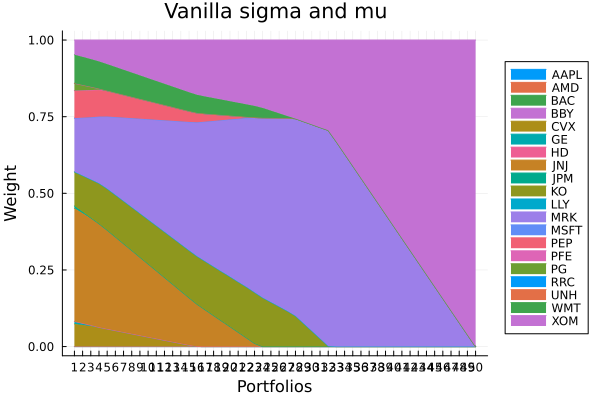

In [11]:
plot_stacked_area_composition(ress[1].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "Vanilla sigma and mu",
                                        legend = :outerright))

Vanilla sigma and mu.

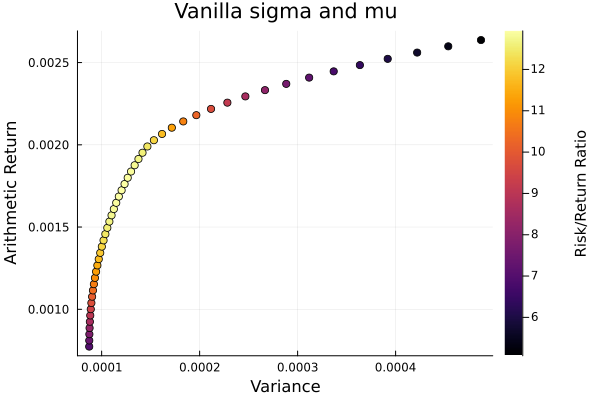

In [12]:
plot_measures(ress[1].w, prs[1]; x = r, y = ReturnRiskMeasure(; rt = ress[1].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[1].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "Vanilla sigma and mu", xlabel = "Variance",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

Fixed denoise sigma, BS(VW) mu.

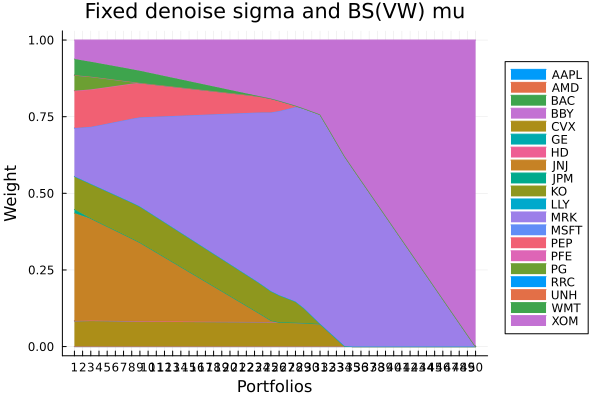

In [13]:
plot_stacked_area_composition(ress[2].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "Fixed denoise sigma and BS(VW) mu",
                                        legend = :outerright))

Fixed denoise covariance.

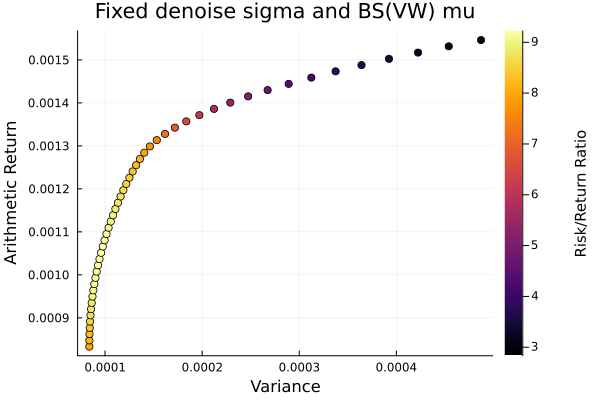

In [14]:
plot_measures(ress[2].w, prs[2]; x = r, y = ReturnRiskMeasure(; rt = ress[2].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[2].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "Fixed denoise sigma and BS(VW) mu", xlabel = "Variance",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

LoGo(MaxDist) sigma and BS(MSE) mu.

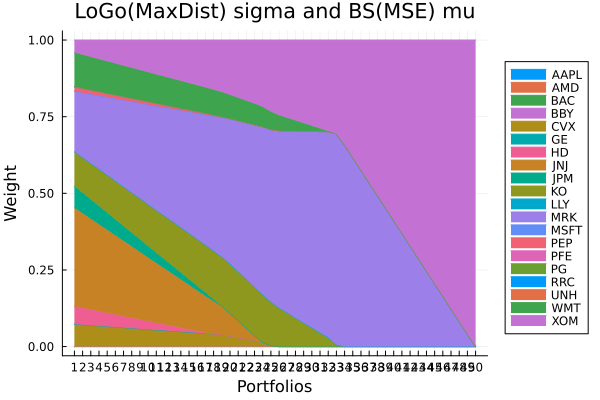

In [15]:
plot_stacked_area_composition(ress[3].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "LoGo(MaxDist) sigma and BS(MSE) mu",
                                        legend = :outerright))

LoGo(MaxDist) covariance.

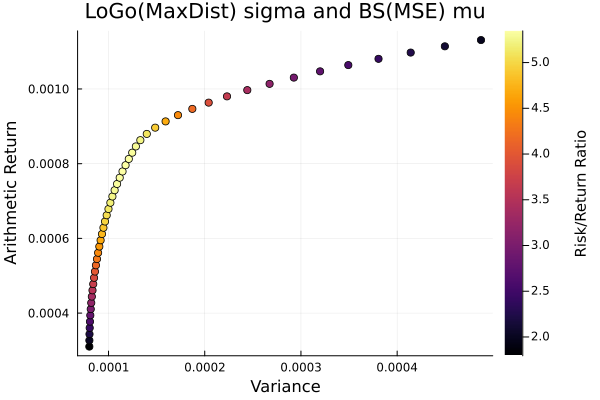

In [16]:
plot_measures(ress[3].w, prs[3]; x = r, y = ReturnRiskMeasure(; rt = ress[3].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[3].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "LoGo(MaxDist) sigma and BS(MSE) mu", xlabel = "Variance",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

Shrunk denoise (0.5) sigma and BOP(GM) mu.

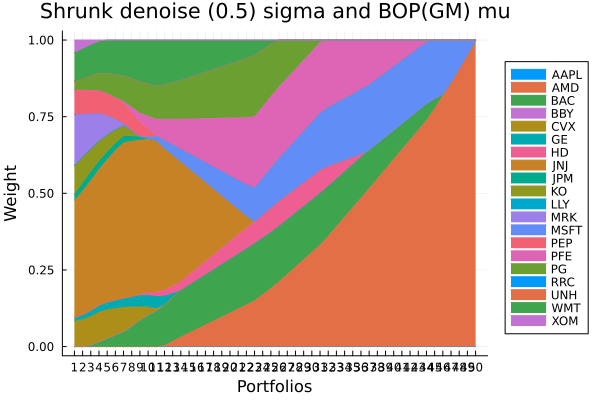

In [17]:
plot_stacked_area_composition(ress[4].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "Shrunk denoise (0.5) sigma and BOP(GM) mu",
                                        legend = :outerright))

Shrunk denoise (0.5) covariance.

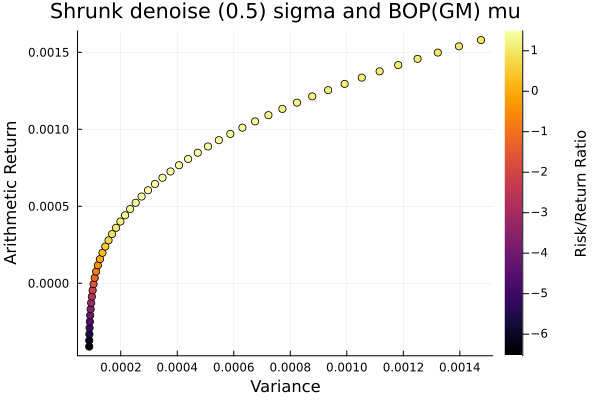

In [18]:
plot_measures(ress[4].w, prs[4]; x = r, y = ReturnRiskMeasure(; rt = ress[4].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[4].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "Shrunk denoise (0.5) sigma and BOP(GM) mu", xlabel = "Variance",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

Fixed denoise + LoGo(MaxDist) sigma and BOP(VW) mu.

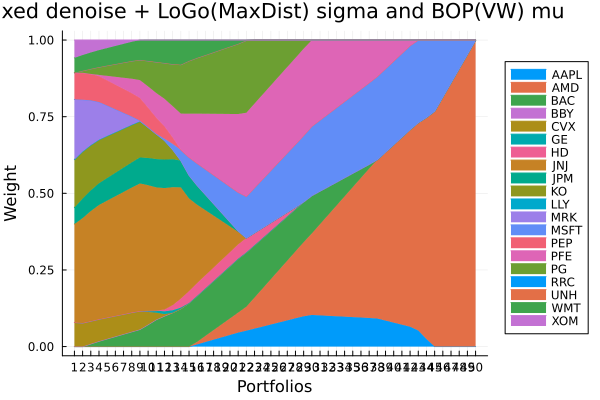

In [19]:
plot_stacked_area_composition(ress[5].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "Fixed denoise + LoGo(MaxDist) sigma and BOP(VW) mu",
                                        legend = :outerright))

Fixed denoise + LoGo(MaxDist) sigma and BOP(VW) mu.

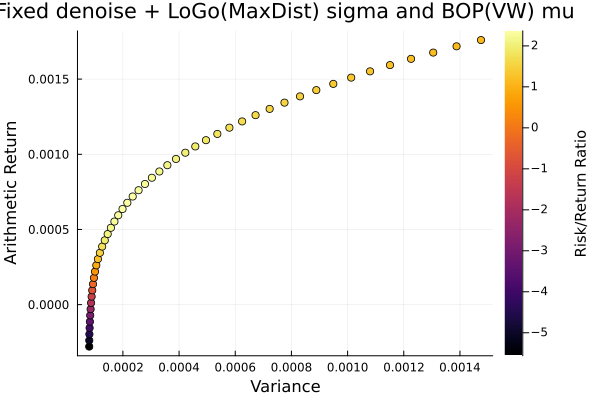

In [20]:
plot_measures(ress[5].w, prs[5]; x = r, y = ReturnRiskMeasure(; rt = ress[5].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[5].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "Fixed denoise + LoGo(MaxDist) sigma and BOP(VW) mu",
              xlabel = "Variance", ylabel = "Arithmetic Return",
              colorbar_title = "\nRisk/Return Ratio", right_margin = 6Plots.mm)

LoGo(ExpDist) sigma and BOP(MSE) mu prior composition.

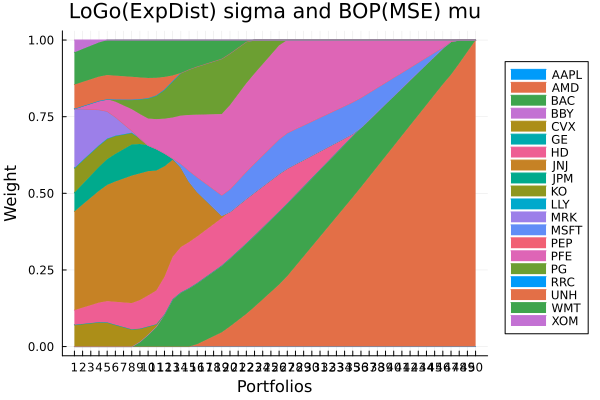

In [21]:
plot_stacked_area_composition(ress[6].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "LoGo(ExpDist) sigma and BOP(MSE) mu",
                                        legend = :outerright))

LoGo(ExpDist) sigma and BOP(MSE) mu.

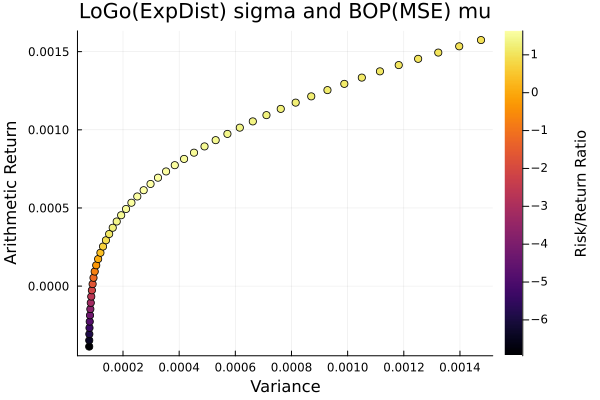

In [22]:
plot_measures(ress[6].w, prs[6]; x = r, y = ReturnRiskMeasure(; rt = ress[6].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[6].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "LoGo(ExpDist) sigma and BOP(MSE) mu", xlabel = "Variance",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

This example is a nice way to show how sensitive moment-based optimisations are to the moment estimation. For now, let's examine how the maximum risk return ratio portfolios differ. An actual analysis would isolate the effect of the covariance and expected returns separately, the point of this example is to show how different ways to improve their estimation and how much the results can be affected by them.

In [23]:
opts = [JuMPOptimiser(; pr = prs[1], slv = slv), JuMPOptimiser(; pr = prs[2], slv = slv),
        JuMPOptimiser(; pr = prs[3], slv = slv), JuMPOptimiser(; pr = prs[4], slv = slv),
        JuMPOptimiser(; pr = prs[5], slv = slv), JuMPOptimiser(; pr = prs[6], slv = slv)]

# Mean-Risk estimators using the variance.
mrs = [MeanRisk(; obj = MaximumRatio(; rf = 4.2 / 100 / 252), opt = opt) for opt in opts]

# Optimise
ress = optimise.(mrs)
pretty_table(DataFrame("Assets" => rd.nx, "Vanilla" => ress[1].w,
                       "Fixed + BS(VW)" => ress[2].w,
                       "LoGo(MaxDist) + BS(MSE)" => ress[3].w,
                       "Shrunk (0.5) + BOP(GM)" => ress[4].w,
                       "Fixed + LoGo(MaxDist) + BOP(VW)" => ress[5].w,
                       "LoGo(ExpDist) + BOP(MSE)" => ress[6].w); formatters = [resfmt])

┌────────┬──────────┬────────────────┬─────────────────────────┬────────────────
│ Assets │  Vanilla │ Fixed + BS(VW) │ LoGo(MaxDist) + BS(MSE) │ Shrunk (0.5)  ⋯
│ String │  Float64 │        Float64 │                 Float64 │               ⋯
├────────┼──────────┼────────────────┼─────────────────────────┼────────────────
│   AAPL │    0.0 % │          0.0 % │                   0.0 % │               ⋯
│    AMD │    0.0 % │          0.0 % │                   0.0 % │               ⋯
│    BAC │    0.0 % │          0.0 % │                   0.0 % │               ⋯
│    BBY │    0.0 % │          0.0 % │                   0.0 % │               ⋯
│    CVX │    0.0 % │        7.684 % │                   0.0 % │               ⋯
│     GE │    0.0 % │          0.0 % │                   0.0 % │               ⋯
│     HD │    0.0 % │          0.0 % │                   0.0 % │               ⋯
│    JNJ │    0.0 % │          0.0 % │                   0.0 % │               ⋯
│    JPM │    0.0 % │       

Portfolios that emphasise expected returns are more sensitive to the expected returns estimation. It is important to exercise caution when relying on expected returns in particular. If one thinks about it, it summarises all returns information into a single number per asset, so any error in its estimation can have a large effect on the resulting portfolio. We will finish on showing these effects in higher order moment optimisation.

### 3.2 Mean-NegativeSkewness optimisation

In [24]:
# JuMP Optimsiers, we will compute the efficient frontier with 50 points for all of them.
opts = [JuMPOptimiser(; pr = prs[4], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[5], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[6], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50)))]

r = NegativeSkewness()
# Mean-Risk estimators using the negative skewness.
mrs = [MeanRisk(; r = r, obj = MinimumRisk(), opt = opt) for opt in opts]

# Optimise
ress = optimise.(mrs)

3-element Vector{MeanRiskResult{DataType, T2, Vector{OptimisationReturnCode}, Vector{JuMPOptimisationSolution}, JuMP.Model, Nothing} where T2}:
 MeanRiskResult
       oe ┼ DataType: DataType
       pa ┼ ProcessedJuMPOptimiserAttributes
          │       pr ┼ HighOrderPrior
          │          │     pr ┼ LowOrderPrior
          │          │        │         X ┼ 252×20 Matrix{Float64}
          │          │        │        mu ┼ 20-element Vector{Float64}
          │          │        │     sigma ┼ 20×20 Matrix{Float64}
          │          │        │      chol ┼ nothing
          │          │        │         w ┼ nothing
          │          │        │       ens ┼ nothing
          │          │        │       kld ┼ nothing
          │          │        │        ow ┼ nothing
          │          │        │        rr ┼ nothing
          │          │        │      f_mu ┼ nothing
          │          │        │   f_sigma ┼ nothing
          │          │        │       f_w ┴ nothing
        

Let's plot the efficient frontiers.

Vanilla V and BOP(GM) mu.

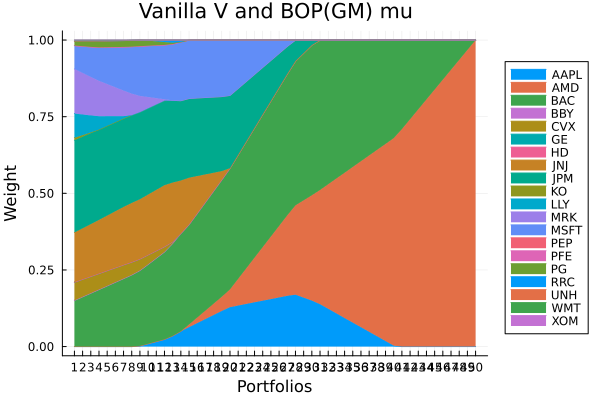

In [25]:
plot_stacked_area_composition(ress[1].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "Vanilla V and BOP(GM) mu",
                                        legend = :outerright))

Vanilla V and BOP(GM) mu.

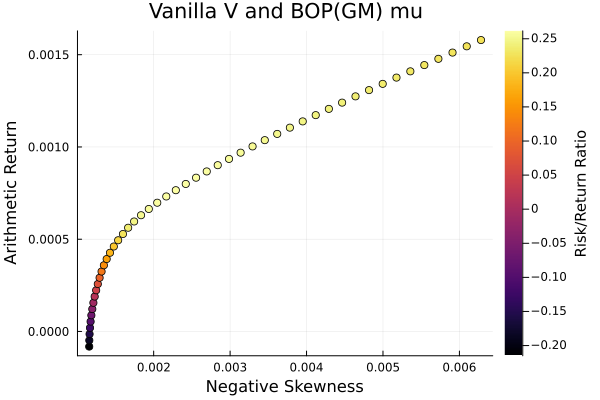

In [26]:
plot_measures(ress[1].w, prs[4]; x = r, y = ReturnRiskMeasure(; rt = ress[1].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[1].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "Vanilla V and BOP(GM) mu", xlabel = "Negative Skewness",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

Fixed Denoise V and BOP(VW) mu.

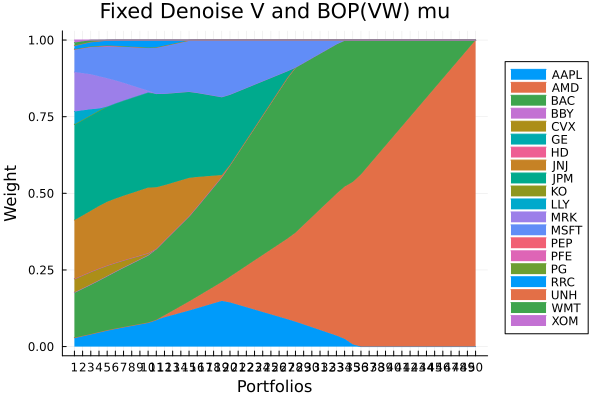

In [27]:
plot_stacked_area_composition(ress[2].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "Fixed Denoise V and BOP(VW) mu",
                                        legend = :outerright))

Fixed Denoise V and BOP(VW) mu.

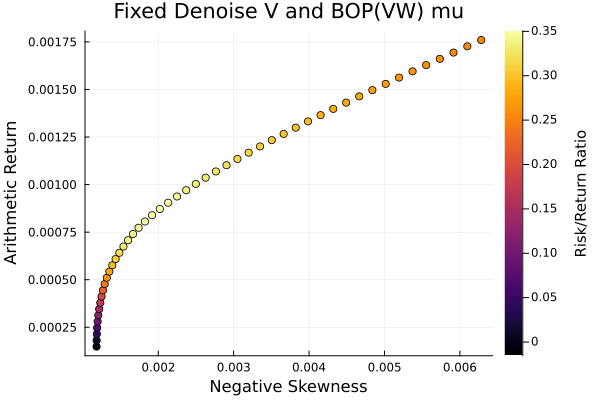

In [28]:
plot_measures(ress[2].w, prs[5]; x = r, y = ReturnRiskMeasure(; rt = ress[2].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[2].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "Fixed Denoise V and BOP(VW) mu", xlabel = "Negative Skewness",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

Shrunk(0) Denoise + LoGo(MaxDist) V and BOP(MSE) mu.

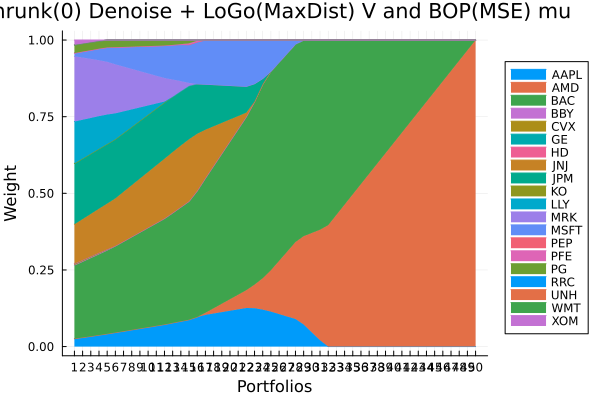

In [29]:
plot_stacked_area_composition(ress[3].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "Shrunk(0) Denoise + LoGo(MaxDist) V and BOP(MSE) mu",
                                        legend = :outerright))

Shrunk(0) Denoise + LoGo(MaxDist) V and BOP(MSE) mu.

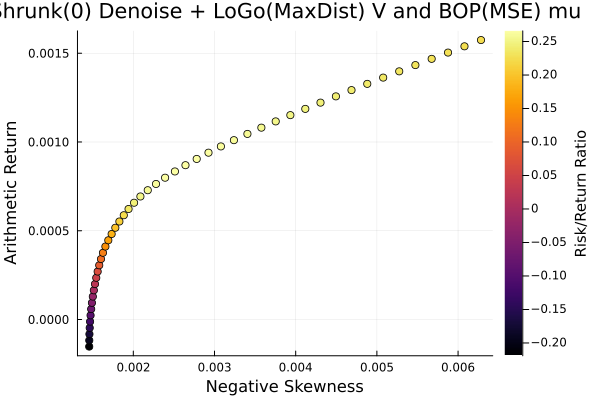

In [30]:
plot_measures(ress[3].w, prs[6]; x = r, y = ReturnRiskMeasure(; rt = ress[3].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[3].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "Shrunk(0) Denoise + LoGo(MaxDist) V and BOP(MSE) mu",
              xlabel = "Negative Skewness", ylabel = "Arithmetic Return",
              colorbar_title = "\nRisk/Return Ratio", right_margin = 6Plots.mm)

In this case we can se that in this case, these techniques denoising and sparsification make the evolution of the portfolio composition along the efficient frontier smoother.

Now let's examine how the maximum risk return ratio portfolios differ.

In [31]:
opts = [JuMPOptimiser(; pr = prs[4], slv = slv), JuMPOptimiser(; pr = prs[5], slv = slv),
        JuMPOptimiser(; pr = prs[6], slv = slv)]

# Mean-Risk estimators using the Negative Skewness.
mrs = [MeanRisk(; r = r, obj = MaximumRatio(; rf = 4.2 / 100 / 252), opt = opt)
       for opt in opts]

# Optimise
ress = optimise.(mrs)
pretty_table(DataFrame("Assets" => rd.nx, "Vanilla V + BOP(GM) mu" => ress[1].w,
                       "Fixed Denoise V + BOP(VW) mu" => ress[2].w,
                       "Shrunk(0) Denoise + LoGo(MaxDist) V + BOP(MSE) mu" => ress[3].w);
             formatters = [resfmt])

┌────────┬────────────────────────┬──────────────────────────────┬──────────────
│ Assets │ Vanilla V + BOP(GM) mu │ Fixed Denoise V + BOP(VW) mu │ Shrunk(0) D ⋯
│ String │                Float64 │                      Float64 │             ⋯
├────────┼────────────────────────┼──────────────────────────────┼──────────────
│   AAPL │                16.24 % │                     13.333 % │             ⋯
│    AMD │               24.414 % │                     11.962 % │             ⋯
│    BAC │               45.563 % │                     39.701 % │             ⋯
│    BBY │                  0.0 % │                        0.0 % │             ⋯
│    CVX │                  0.0 % │                        0.0 % │             ⋯
│     GE │                  0.0 % │                        0.0 % │             ⋯
│     HD │                  0.0 % │                        0.0 % │             ⋯
│    JNJ │                  0.0 % │                        0.0 % │             ⋯
│    JPM │               10.

Similarly to the mean-variance case, the more one emphasises the expected returns, the less stable the resulting portfolio. Generally, it's better to use a volatility weighted shrinkage target for the expected returns as that adjusts the expected returns by penalising high volatility and rewarding low volatility assets.

### 3.3 Mean-Kurtosis optimisation

Finally, we will see how the cokurtosis estimation improvements affect the mean-kurtosis optimisation along the efficient frontier.

In [32]:
# JuMP Optimsiers, we will compute the efficient frontier with 50 points for all of them.
opts = [JuMPOptimiser(; pr = prs[4], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[5], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50))),
        JuMPOptimiser(; pr = prs[6], slv = slv,
                      ret = ArithmeticReturn(; lb = Frontier(; N = 50)))]

r = Kurtosis()
# Mean-Risk estimators using the kurtosis.
mrs = [MeanRisk(; r = r, obj = MinimumRisk(), opt = opt) for opt in opts]

# Optimise
ress = optimise.(mrs)

3-element Vector{MeanRiskResult{DataType, T2, Vector{OptimisationReturnCode}, Vector{JuMPOptimisationSolution}, JuMP.Model, Nothing} where T2}:
 MeanRiskResult
       oe ┼ DataType: DataType
       pa ┼ ProcessedJuMPOptimiserAttributes
          │       pr ┼ HighOrderPrior
          │          │     pr ┼ LowOrderPrior
          │          │        │         X ┼ 252×20 Matrix{Float64}
          │          │        │        mu ┼ 20-element Vector{Float64}
          │          │        │     sigma ┼ 20×20 Matrix{Float64}
          │          │        │      chol ┼ nothing
          │          │        │         w ┼ nothing
          │          │        │       ens ┼ nothing
          │          │        │       kld ┼ nothing
          │          │        │        ow ┼ nothing
          │          │        │        rr ┼ nothing
          │          │        │      f_mu ┼ nothing
          │          │        │   f_sigma ┼ nothing
          │          │        │       f_w ┴ nothing
        

Let's plot the efficient frontiers.

Vanilla kt and BOP(GM) mu.

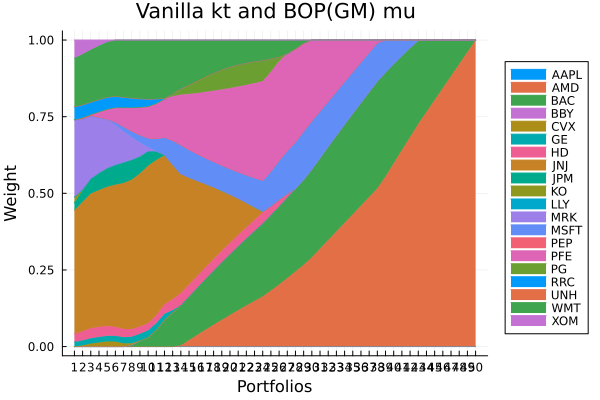

In [33]:
plot_stacked_area_composition(ress[1].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "Vanilla kt and BOP(GM) mu",
                                        legend = :outerright))

Vanilla kt and BOP(GM) mu.

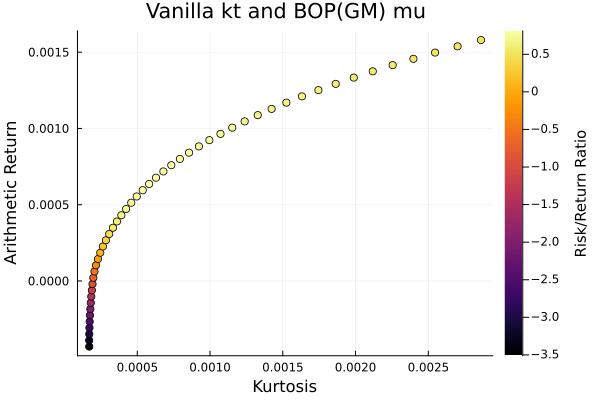

In [34]:
plot_measures(ress[1].w, prs[4]; x = r, y = ReturnRiskMeasure(; rt = ress[1].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[1].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "Vanilla kt and BOP(GM) mu", xlabel = "Kurtosis",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

Fixed Denoise kt and BOP(VW) mu.

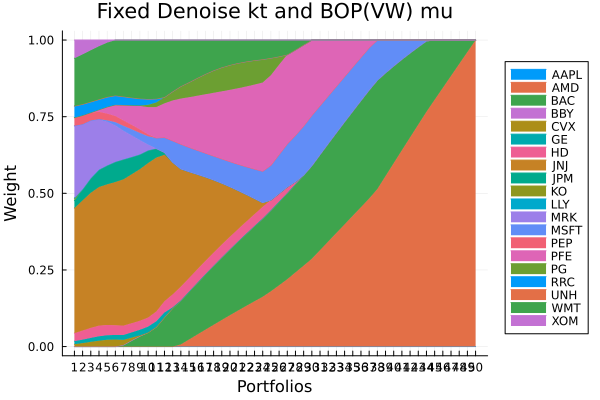

In [35]:
plot_stacked_area_composition(ress[2].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "Fixed Denoise kt and BOP(VW) mu",
                                        legend = :outerright))

Fixed Denoise kt and BOP(VW) mu.

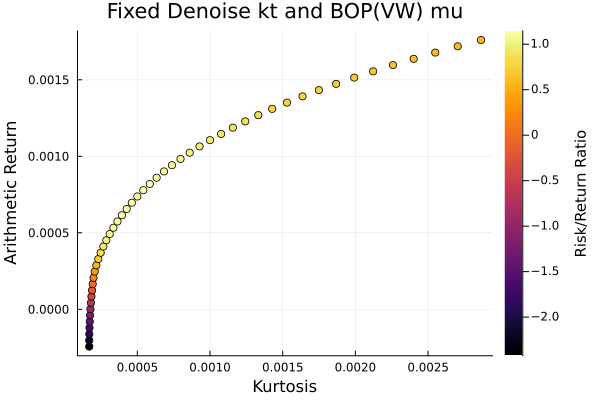

In [36]:
plot_measures(ress[2].w, prs[5]; x = r, y = ReturnRiskMeasure(; rt = ress[2].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[2].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "Fixed Denoise kt and BOP(VW) mu", xlabel = "Kurtosis",
              ylabel = "Arithmetic Return", colorbar_title = "\nRisk/Return Ratio",
              right_margin = 6Plots.mm)

Shrunk(0) Denoise + LoGo(MaxDist) kt and BOP(MSE) mu.

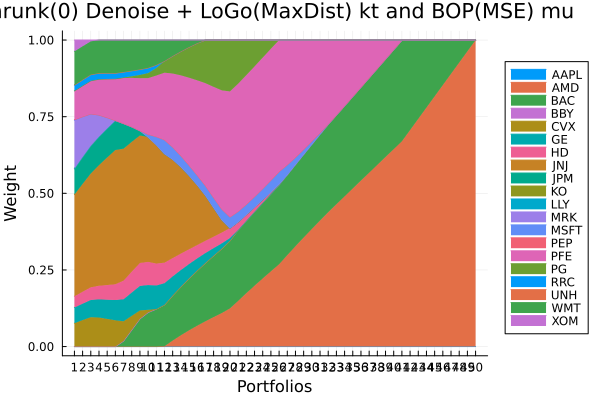

In [37]:
plot_stacked_area_composition(ress[3].w, rd.nx;
                              kwargs = (; xlabel = "Portfolios", ylabel = "Weight",
                                        title = "Shrunk(0) Denoise + LoGo(MaxDist) kt and BOP(MSE) mu",
                                        legend = :outerright))

Shrunk(0) Denoise + LoGo(MaxDist) kt and BOP(MSE) mu.

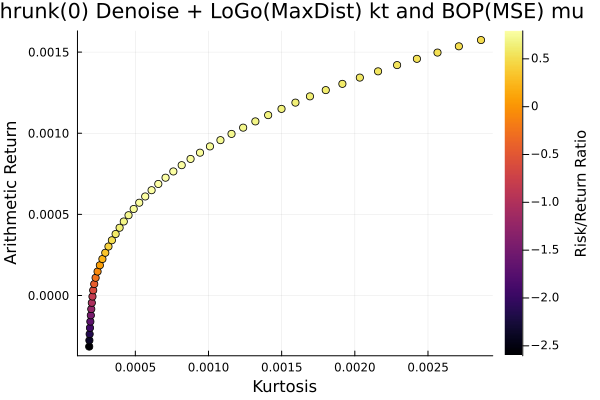

In [38]:
plot_measures(ress[3].w, prs[6]; x = r, y = ReturnRiskMeasure(; rt = ress[3].ret),
              c = ReturnRiskRatioRiskMeasure(; rt = ress[3].ret, rk = r,
                                             rf = 4.2 / 100 / 252),
              title = "Shrunk(0) Denoise + LoGo(MaxDist) kt and BOP(MSE) mu",
              xlabel = "Kurtosis", ylabel = "Arithmetic Return",
              colorbar_title = "\nRisk/Return Ratio", right_margin = 6Plots.mm)

Again, the efficient frontier is smoother, but the kurtosis is inherently less stable than the variance and negative skewness, so the improvements are less pronounced.

Finally let's see what the maximum risk return ratio portfolios look like.

In [39]:
opts = [JuMPOptimiser(; pr = prs[4], slv = slv), JuMPOptimiser(; pr = prs[5], slv = slv),
        JuMPOptimiser(; pr = prs[6], slv = slv)]

# Mean-Risk estimators using the Kurtosis.
mrs = [MeanRisk(; r = r, obj = MaximumRatio(; rf = 4.2 / 100 / 252), opt = opt)
       for opt in opts]

# Optimise
ress = optimise.(mrs)
pretty_table(DataFrame("Assets" => rd.nx, "Vanilla kt + BOP(GM) mu" => ress[1].w,
                       "Fixed Denoise kt + BOP(VW) mu" => ress[2].w,
                       "Shrunk(0) Denoise + LoGo(MaxDist) kt + BOP(MSE) mu" => ress[3].w);
             formatters = [resfmt])

┌────────┬─────────────────────────┬───────────────────────────────┬────────────
│ Assets │ Vanilla kt + BOP(GM) mu │ Fixed Denoise kt + BOP(VW) mu │ Shrunk(0) ⋯
│ String │                 Float64 │                       Float64 │           ⋯
├────────┼─────────────────────────┼───────────────────────────────┼────────────
│   AAPL │                   0.0 % │                         0.0 % │           ⋯
│    AMD │                25.392 % │                      15.762 % │           ⋯
│    BAC │                27.372 % │                      25.221 % │           ⋯
│    BBY │                   0.0 % │                         0.0 % │           ⋯
│    CVX │                   0.0 % │                         0.0 % │           ⋯
│     GE │                   0.0 % │                         0.0 % │           ⋯
│     HD │                   0.0 % │                       3.799 % │           ⋯
│    JNJ │                   0.0 % │                       2.681 % │           ⋯
│    JPM │                  

Generally, the volatility weighted target for expected returns combined with fixed denoise, performs quite well. That's not to say other methdos are not useful. It's worth using different techniques and comparing the results. For example with cross validation, which is as of yet unimplemented in `PortfolioOptimisers.jl`. Even so, it's never an exact science. It's always best to combine techniques, which is why we provide users with the ability to use multiple risk measures like in [`06_Multiple_Risk_Measures`](https://dcelisgarza.github.io/PortfolioOptimisers.jl/stable/examples/06_Multiple_Risk_Measures). There are also other ways of directly mitigating these instabilities raging:

1. Estimators like [`Stacking`]-(@ref) and [`NearOptimalCentering`]-(@ref).
2. Uncertainty sets for the expected returns and covariance matrices.
3. Logarithmic returns direclty in the optimisation.
4. L1 and L2 regularisation.
5. Buy-in threshold constraints.
6. Phylogeny constraints.

These are a few things direclty reduce the impact of moment estimation errors on the resulting portfolios, but can be used with other risk measures as well.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*